In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import pandas as pd
import json
import rasterio.mask
from rasterio.mask import mask
import rasterio.plot
from rasterio.plot import show
import matplotlib.colors as pltc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
import rasterio.warp
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
from rasterio.merge import merge
import glob
import os
%matplotlib inline

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
data_dir = "C:/Users/yoko1/Downloads/"

In [13]:
test = rasterio.open(data_dir + "./Hansen_GFC-2020-v1.8_lossyear_40N_080W.tif")

In [ ]:
data_dir2 = "C:/Users/yoko1/Box/ACE 592 Project/zambia adm shp/"
zambia_file = data_dir2 + "ZMB_adm2.shp"
zambia = geopandas.read_file(zambia_file)

In [7]:
zambia.crs == test.crs

True

<AxesSubplot:>

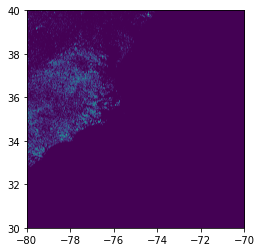

In [14]:
fig, ax = plt.subplots()
rasterio.plot.show(test, ax=ax)
#zambia.plot(ax=ax, facecolor='none', edgecolor='black')

<AxesSubplot:>

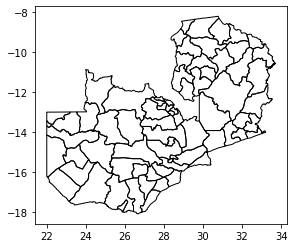

In [17]:
fig, ax = plt.subplots()
zambia.plot(ax=ax, facecolor='none', edgecolor='black')

## 1. Merge and mosaic raster files
From https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-mosaic.html

In [3]:
# File and folder paths
data_dir = "C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file/"
out_fp = os.path.join(data_dir, "zambia_treeloss.tif")

# Make a search criteria to select the DEM files
search_criteria = "Hansen_GFC-2019-v1.7_lossyear_*.tif"
q = os.path.join(data_dir, search_criteria)
print(q)

C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file/Hansen_GFC-2019-v1.7_lossyear_*.tif


In [4]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\\Hansen_GFC-2019-v1.7_lossyear_00N_020E.tif',
 'C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\\Hansen_GFC-2019-v1.7_lossyear_00N_030E.tif',
 'C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\\Hansen_GFC-2019-v1.7_lossyear_10S_020E.tif',
 'C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\\Hansen_GFC-2019-v1.7_lossyear_10S_030E.tif']

In [5]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\Hansen_GFC-2019-v1.7_lossyear_00N_020E.tif' mode='r'>,
 <open DatasetReader name='C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\Hansen_GFC-2019-v1.7_lossyear_00N_030E.tif' mode='r'>,
 <open DatasetReader name='C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\Hansen_GFC-2019-v1.7_lossyear_10S_020E.tif' mode='r'>,
 <open DatasetReader name='C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file\Hansen_GFC-2019-v1.7_lossyear_10S_030E.tif' mode='r'>]

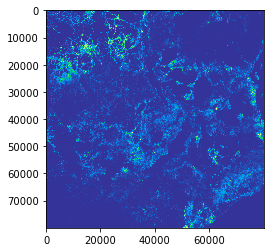

<AxesSubplot:>

In [6]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap='terrain')

In [7]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )

In [8]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

https://cran.r-project.org/web/packages/exactextractr/vignettes/vig2_categorical.html

In [9]:
data_dir = "C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file/"

In [10]:
test = rasterio.open(data_dir + "zambia_treeloss.tif")

In [11]:
data_dir2 = "C:/Users/mliu11/Box/ACE 592 Project/zambia adm shp/"
zambia_file = data_dir2 + "ZMB_adm2.shp"
zambia = geopandas.read_file(zambia_file)

<AxesSubplot:>

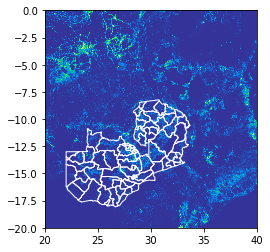

In [12]:
fig, ax = plt.subplots()
rasterio.plot.show(test, cmap='terrain', ax=ax)
zambia.plot(ax=ax, facecolor='none', edgecolor='white')

In [18]:
img_out, img_transform = mask(test,shapes,crop=True) 


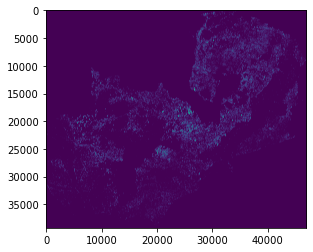

In [19]:
plt.imshow(img_out[0,:,:])

In [33]:
import glob
import os
import fiona

data_dir = "C:/Users/mliu11/Box/ACE 592 Project/Deforestation data/raster file/"

with fiona.open("C:/Users/mliu11/Box/ACE 592 Project/zambia adm shp/zmb_admbnda_adm0_dmmu_20201124.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

img_out, img_transform = mask(test,shapes,crop=True) 

img_out = img_out[:,:,:]

out_meta = test.meta.copy()
out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform
        
out_meta['nodata'] = 0
        
with rasterio.open(data_dir+"./zambia_deforestation.tif", "w", **out_meta) as dest:
            dest.write(img_out)

In [26]:
deforestation = rasterio.open(data_dir + "zambia_deforestation.tif")

<AxesSubplot:>

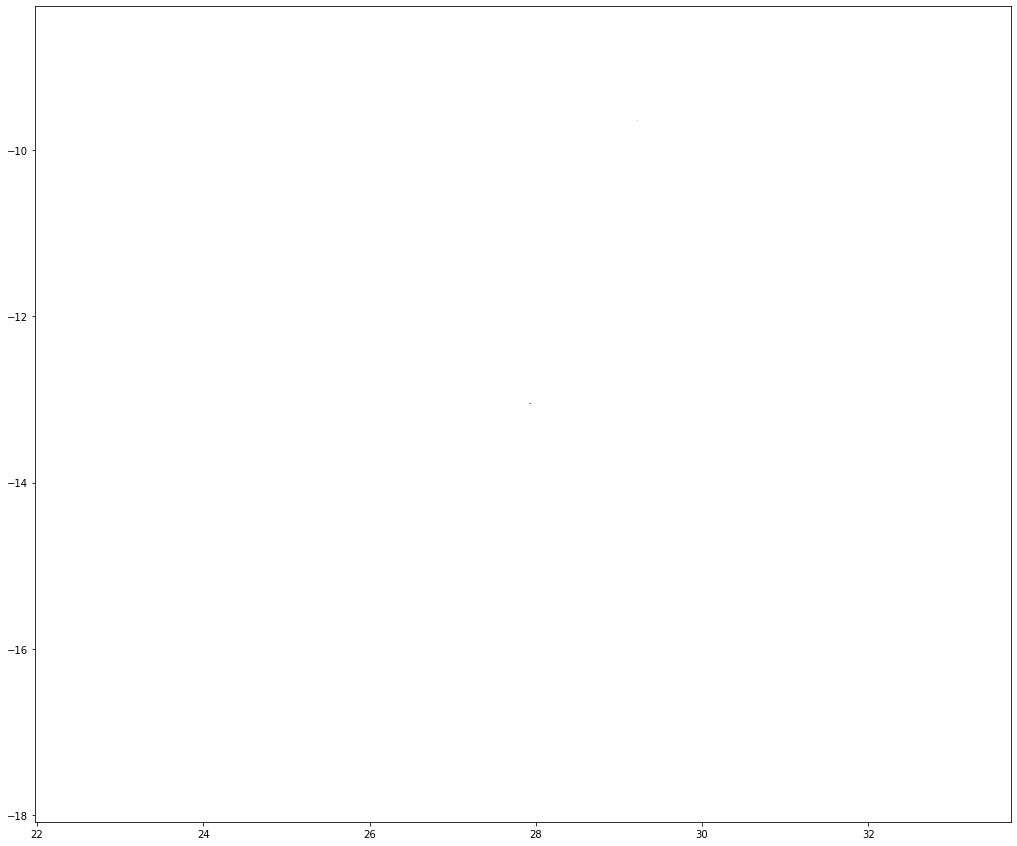

In [30]:
fig, ax = plt.subplots(figsize=(25, 15))
rasterio.plot.show(deforestation, cmap='terrain', ax=ax)

In [15]:
data_dir2 = "C:/Users/mliu11/Box/ACE 592 Project/zambia adm shp/"
zambia_file = data_dir2 + "ZMB_adm2.shp"

In [16]:
zambia = geopandas.read_file(zambia_file)

<AxesSubplot:>

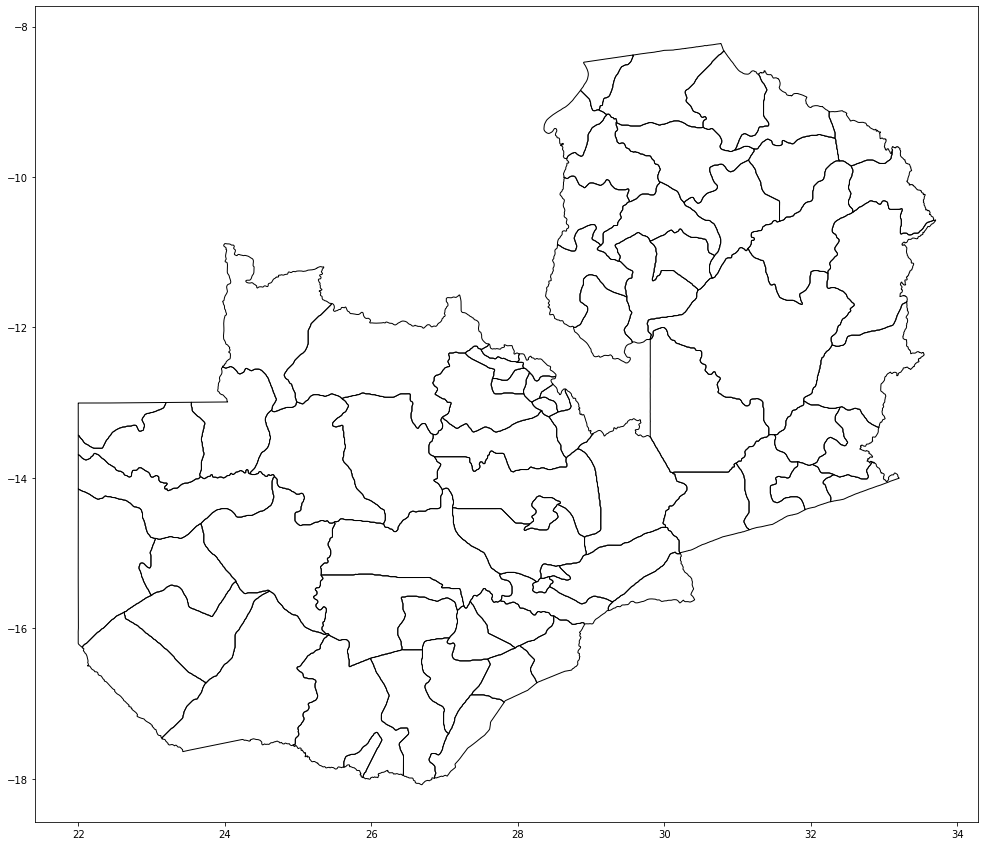

In [29]:
fig, ax = plt.subplots(figsize=(25, 15))
zambia.plot(ax=ax, facecolor='none', edgecolor='black')

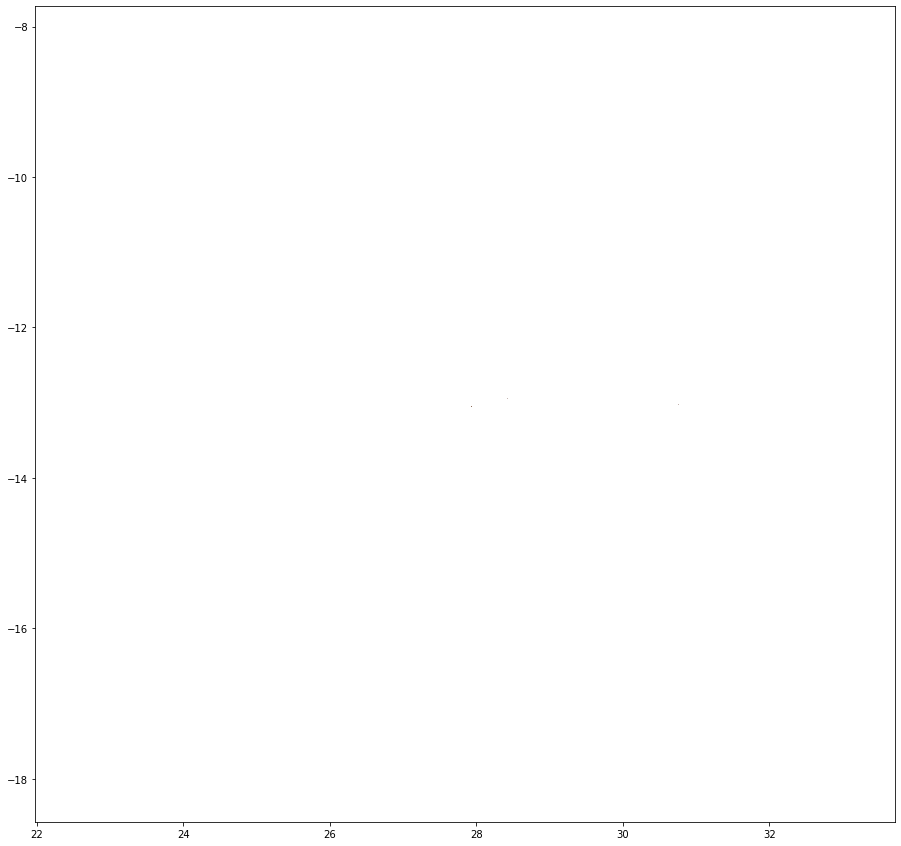

In [17]:
fig, ax = plt.subplots(figsize=(25, 15))
rasterio.plot.show(deforestation, cmap='terrain', ax=ax)
zambia.plot(ax=ax, facecolor='none', edgecolor='black')

fig.savefig("C:/Users/mliu11/Box/ACE 592 Project/figures/deforestation_map.png",dpi=300, bbox_inches = "tight")

## Please disregard from here

In [19]:
zambia.crs == test.crs

False

In [31]:
zambia = zambia.to_crs(test.crs)

In [38]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [39]:
def clip_raster(raster,vector,filename):
    img_out, img_transform = mask(raster,getFeatures(vector))
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [41]:
zambia_deforestation = clip_raster(test,zambia,"zambia_deforestation")

C:\Users\yoko1\anaconda3\envs\geo\lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


## 2. Mapping from here

In [8]:
data_dir = "C:/Users/yoko1/Box/ACE592 - data sience/"
test = rasterio.open(data_dir + "zambia_deforestation.tif")

data_dir2 = "C:/Users/mliu11/Box/ACE 592 Project/zambia adm shp/"
zambia_file = data_dir2 + "ZMB_adm2.shp"
zambia = geopandas.read_file(zambia_file)

In [11]:
zambia.crs == test.crs

True

In [12]:
zambia = zambia.to_crs(test.crs)

<AxesSubplot:>

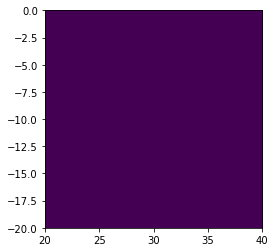

In [14]:
fig, ax = plt.subplots()
rasterio.plot.show(test, ax=ax)
#zambia.plot(ax=ax, facecolor='none', edgecolor='black')

In [ ]:
test = rasterio.open(data_dir + "./Hansen_GFC-2020-v1.8_lossyear_40N_080W.tif")